# DDM

We'll be using differential dynamic microscopy. This technique was first described in 2008 in an article in PRL by Cerbino and Trappe. 
![PRL image](DDM_Paper_PRL.PNG)
You can find the paper [here](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.100.188102). 

In [1]:
#importing the required modules
import numpy as np #Numerical Python
import scipy #Scientific Python
from scipy.optimize import leastsq #for least-squares fitting
from scipy.signal import blackmanharris as bh #for potentially filtering raw images

%matplotlib inline
import mpld3 #For making nice looking plots
mpld3.enable_notebook()
import matplotlib #for plotting and displaying images
from matplotlib import pylab

#For making interactive user interfaces (buttons and sliders and such)
import ipywidgets as widgets
from ipywidgets import Layout, interact, fixed

#Loading the particle tracking software
import sys
sys.path.append("Z:\\Code\\BeadTracking\\track") #Locate code
import tiff_file #Ignore any warnings importing this may cause

Z:\Code\BeadTracking\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
Z:\Code\BeadTracking\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
Z:\Code\BeadTracking\track\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


Below is the heart of the DDM analysis. The function computes the image structure function by taking the average of the Fourier transforms of all image differences. The image differences are found for a particular set of lag times (given as the second parameter to this function).

Mathematically, we find the difference between images separated by some lag time $\Delta t$:
$$\Delta I = I(x,y,t) - I(x,y,\Delta t)$$

For a given $\Delta t$ all such image differences are calculated. We then Fourier transform each $\Delta I$ and average all of the same $\Delta t$.

This results in the image structure function $D(q_x,q_y,\Delta t)$.

In [2]:
def getFFTDiffsAtTimes(imageFile, dts, numAvgs=30, limitImsTo=None, every=None):
    if isinstance(imageFile, np.ndarray):
        ims = imageFile
    elif isinstance(imageFile, basestring):
        ims = tiff_file.imread(imageFile)
    else:
        print "Not sure what you gave for imageFile"
        return 0
    if limitImsTo is not None:
        ims = ims[:limitImsTo]
    if every is not None:
        ims = ims[::every]

    ntimes, ndx, ndy = ims.shape

    fft_diffs = np.zeros((len(dts), ndx, ndy),dtype=np.float)

    j=0
    for dt in dts:
        if dt%15 == 0:
            print "Running dt=%i...\n" % dt
        
        all_diffs = ims[dt:].astype(np.float) - ims[0:(-1*dt)].astype(np.float)
        num_to_av = min(numAvgs, all_diffs.shape[0])
        ones_to_average = np.linspace(0, all_diffs.shape[0], num_to_av, endpoint=False, dtype=np.int)
        for i in ones_to_average:
            temp = np.fft.fft2(all_diffs[i] - all_diffs[i].mean())
            fft_diffs[j] = fft_diffs[j] + abs(temp*np.conj(temp))/(ndx*ndy)
        fft_diffs[j] = fft_diffs[j] / num_to_av
        
        fft_diffs[j] = np.fft.fftshift(fft_diffs[j])
        j = j+1

    return fft_diffs

Here are some helper functions to do the analysis. 

In [36]:
def newRadav(im):
    '''
    Radially averages a 2D array
    '''
    nx,ny = im.shape
    xx = np.arange(-(nx-1)/2., nx/2.)
    yy = np.arange(-(ny-1)/2., ny/2.)
    x,y = np.meshgrid(yy,xx)
    q = np.sqrt(x**2 + y**2)
    qr = q.round().astype(np.int)
    rs = np.arange(0,(max(nx,ny)-1)/2) 
    radav = np.zeros((len(rs)),dtype=np.float)
    for i in range(0,len(rs)):
        w = np.where(qr==rs[i])
        if len(w[0])>0:
            radav[i] = np.nanmean(im[w])
    return radav

def radialAvFFTs_v2(fft_diff):
    '''
    This function takes a 3D array and radially
    averages each slice
    '''
    radav = newRadav(fft_diff[0])
    ravs = np.zeros((fft_diff.shape[0], len(radav)))
    ravs[0] = radav
    for i in range(1,fft_diff.shape[0]):
        ravs[i] = newRadav(fft_diff[i])
    return ravs

def dTheorySingle(x,a1,t1,bg):
    '''
    x: lag times
    a1: amplitude
    t1: characteristic decay time
    bg: background
    '''
    g1 = np.exp(-1 * (x / t1))
    d = a1 * (1 - g1) + bg
    return d

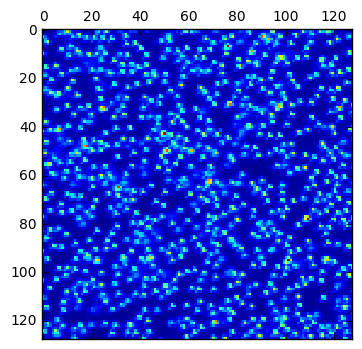

In [3]:
data_directory = "Z:\\Code\PythonCode\\OT_Setup\\python_scripts\\ExampleData\\"
data_file = "FOR_DDM_20x_18.88fps_2x2bin.tif"
images_frame0 = tiff_file.imread(data_directory+data_file, key=0)
pylab.matshow(images_frame0)

In [38]:
#Set up the time lags we'll use to calculate the 
#image structure function
dts=np.unique(np.geomspace(1,599,100,dtype=np.int))
print "Number of time lags: %i" % len(dts)

Number of time lags: 72


In [7]:
d = getFFTDiffsAtTimes(data_directory+data_file, dts)

Running dt=15...

Running dt=30...

Running dt=45...

Running dt=75...

Running dt=135...



In [25]:
#After running the above you can check the dimensions of d
#The first dimension should be the number of time lags.
#The next two dimensions are the shape of the images acquired
print d.shape

(72L, 128L, 128L)


C:\Users\rmcgorty\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


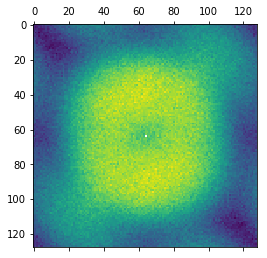

In [8]:
pylab.matshow(np.log(d[10]))

In [39]:
ravs = radialAvFFTs_v2(d)

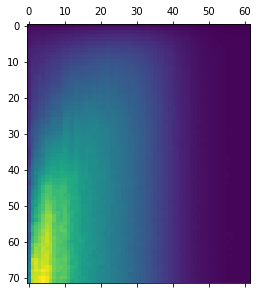

In [40]:
pylab.matshow(ravs[:,1:])

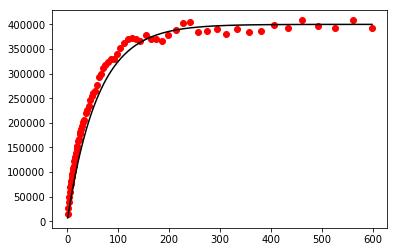

In [49]:
pylab.plot(dts,ravs[:,10],'ro')
params = np.array([4.0e5, 60, 1e2])
pylab.plot(dts, dTheorySingle(dts, *params),'-k')

In [52]:
errFunc = lambda params, data, dts: data - dTheorySingle(dts, *params)
fitParams, flag = leastsq(errFunc, params, args=(ravs[:,10], dts))

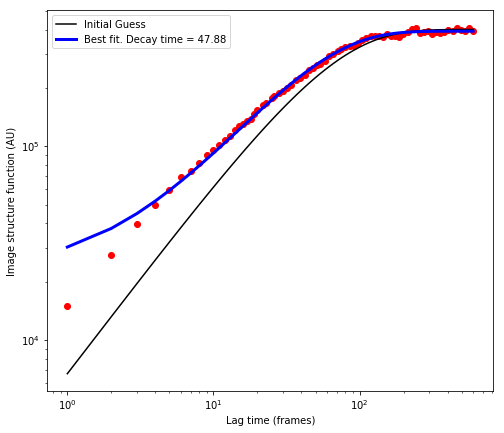

In [53]:
fig,ax = plt.subplots(figsize=(8,7))
ax.loglog(dts,ravs[:,10],'ro')
ax.plot(dts, dTheorySingle(dts, *params),'-k', label="Initial Guess")
ax.plot(dts, dTheorySingle(dts, *fitParams),'-b', lw=3, label="Best fit. Decay time = %.2f" % fitParams[1])
ax.set_xlabel("Lag time (frames)")
ax.set_ylabel("Image structure function (AU)")
ax.legend(loc=0)

In [55]:
all_decay_times = []
spatial_frequencies = np.arange(10,50,2)
for freq in spatial_frequencies:
    fitParams, flag = leastsq(errFunc, params, args=(ravs[:,freq], dts))
    all_decay_times.append(fitParams[1])
    params = fitParams #this way, the next initial guess will use the last found best fit parameters

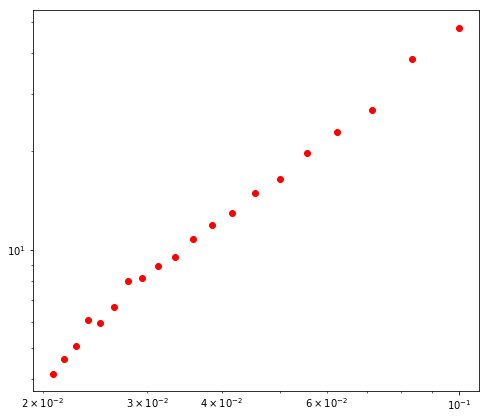

In [57]:
fig,ax = plt.subplots(figsize=(8,7))
ax.loglog(1./spatial_frequencies, all_decay_times,'ro')